# Analyse des sessions

On va s'intéresser dans cette section à l'historique des activités (sessions) des utilisateurs. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [3]:
users = pd.read_csv('data/train_users_2.csv')
test_users = pd.read_csv('data/test_users.csv')
sessions = pd.read_csv('data/sessions.csv')

users['found_destination'] = users.apply(lambda r: 'DF' if r['country_destination'] != 'NDF' else 'NDF', axis=1)

On a vu, dans l'introduction, qu'on ne dispose pas des sessions de tous les utilisateurs. De ce fait, on va sélectioner les utilisateurs qui ont une session avant d'équilibrer les classes (DF/NDF).

In [4]:
# Extract user ids who have sessions
base_user_ids = sessions['user_id'].unique()
base_user_ids = base_user_ids.tolist()
base_user_ids.remove(np.nan)

# Remove user ids who are from the test set
test_user_ids = test_users['id'].values
base_user_ids = list(set(base_user_ids) - set(test_user_ids))

# Select sessions with the remaining ids
users_by_ids = users.set_index('id')
session_users = users_by_ids.loc[base_user_ids]

# Balance DF and NDF labels
session_users_ndf = session_users[session_users['found_destination'] == 'NDF'].head(20000)
session_users_df = session_users[session_users['found_destination'] == 'DF'].head(20000)
session_users = pd.concat([session_users_ndf, session_users_df])

sessions = sessions[sessions['user_id'].isin(session_users.index)]
print(f'sessions.shape : {sessions.shape}')  # One user is represented in many rows since one user can do many actions
sessions.head()

sessions.shape : (3103087, 6)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
304,4rvqpxoh3h,campaigns,-unknown-,-unknown-,iPhone,375.0
305,4rvqpxoh3h,active,-unknown-,-unknown-,iPhone,728.0
306,4rvqpxoh3h,create,-unknown-,-unknown-,iPhone,NaN
307,4rvqpxoh3h,notifications,-unknown-,-unknown-,iPhone,187.0
308,4rvqpxoh3h,listings,-unknown-,-unknown-,iPhone,154.0


On a 20000 + 20000 utilisateurs DF et NDF.

In [5]:
# Add column found_destination {DF, NDF}
sessions = sessions.merge(users.rename({"id":"user_id"}, axis=1)[['found_destination', 'user_id']], on='user_id', how='inner')

## Temps écoulé

Affichons le temps que les utilisateurs ont passé sur le site (somme du temps écoulé par activités).

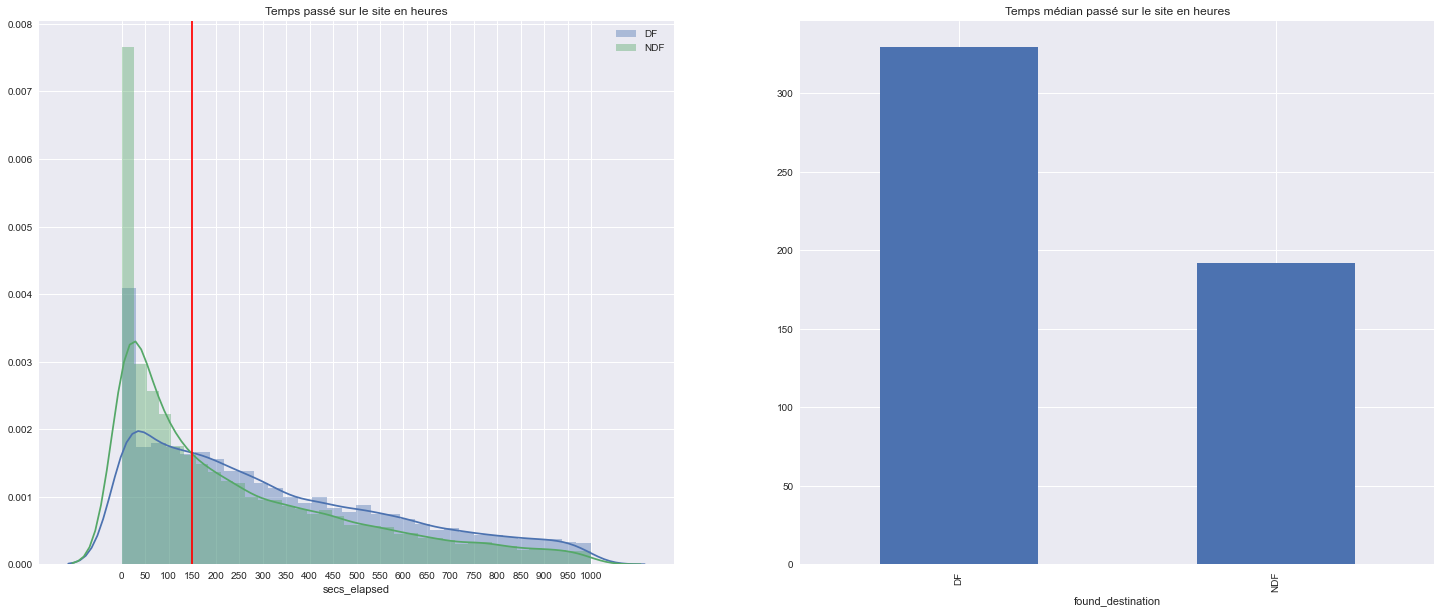

In [6]:
time_elapsed = sessions.groupby(['user_id', 'found_destination'])['secs_elapsed'].sum() / (60**2)
f = plt.figure(figsize=(25, 10))
f.add_subplot(1, 2, 1)
sns.distplot(time_elapsed[time_elapsed < 1000].loc[:,'DF'], label='DF')
sns.distplot(time_elapsed[time_elapsed < 1000].loc[:,'NDF'], label='NDF')
plt.xticks(np.linspace(0, 1000, 21))
plt.axvline(150, 0, 1, color='r')
plt.title("Temps passé sur le site en heures")
plt.legend()

f.add_subplot(1, 2, 2)
time_elapsed.groupby('found_destination').median().plot(kind='bar')
_ = plt.title("Temps médian passé sur le site en heures")

Globalement, le nombre d'heures passées en relativement élevé (de l'ordre de la centaine) si on considère que toutes ces activités se sont passées avant la première réservation. C'est pourquoi, il est très probable les activités post-reservations sont également enregistrées.

Les DF passent beaucoup plus de temps sur le site que les NDF, probablement car ils font l'effort de renseigner leur profil, passer du temps sur les différentes annonces, écrire aux hôtes pour poser des questions, etc. Il est possible qu'une partie des NDF ne font que regarder, mais ce ne sont que des suppositions. 

## La nature des actions effectuées par les utilisateurs

On va étudier les actions effectués par les utilisateurs.

In [7]:
col_names = ['action', 'action_type', 'action_detail']
for col in col_names:
    sessions[col] = sessions[col].fillna('_')
sessions.groupby(col_names).count()['user_id'].describe()

count       382.000000
mean       8123.264398
std       32961.518146
min           1.000000
25%          21.250000
50%         233.500000
75%        2430.500000
max      339912.000000
Name: user_id, dtype: float64

On compte près de 389 actions différentes. Une action a été effectuée plus de 300_000 fois, d'autres qu'une seule fois.

On va récupérer les actions (colonnes "action" + "action_type" + "action_detail") les plus présentes chez les DF puis chez les NDF.

In [8]:
# Concat actions
sessions['action_name'] = sessions['action'] + '-' + sessions['action_type'] + '-' + sessions['action_detail']
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed,found_destination,action_name
0,4rvqpxoh3h,campaigns,-unknown-,-unknown-,iPhone,375.0,DF,campaigns--unknown---unknown-
1,4rvqpxoh3h,active,-unknown-,-unknown-,iPhone,728.0,DF,active--unknown---unknown-
2,4rvqpxoh3h,create,-unknown-,-unknown-,iPhone,NaN,DF,create--unknown---unknown-
3,4rvqpxoh3h,notifications,-unknown-,-unknown-,iPhone,187.0,DF,notifications--unknown---unknown-
4,4rvqpxoh3h,listings,-unknown-,-unknown-,iPhone,154.0,DF,listings--unknown---unknown-


In [9]:
# Count number of users who did a specified action in column 
counts = sessions.groupby(['found_destination', 'action_name']).agg({'user_id': pd.Series.nunique}).rename(columns={'user_id':'count'})

# Separate DF and NDF group
action_names_stats_df = counts.loc['DF'].reset_index().rename({'count': 'count_df'}, axis=1)
action_names_stats_ndf = counts.loc['NDF'].reset_index().rename({'count': 'count_ndf'}, axis=1)

# Merge DataFrame into one
action_names_stats = action_names_stats_df.merge(action_names_stats_ndf, on='action_name', how='outer').fillna(0)
action_names_stats['diff'] = (action_names_stats['count_df'] - action_names_stats['count_ndf']) / (action_names_stats['count_df'] + action_names_stats['count_ndf'])

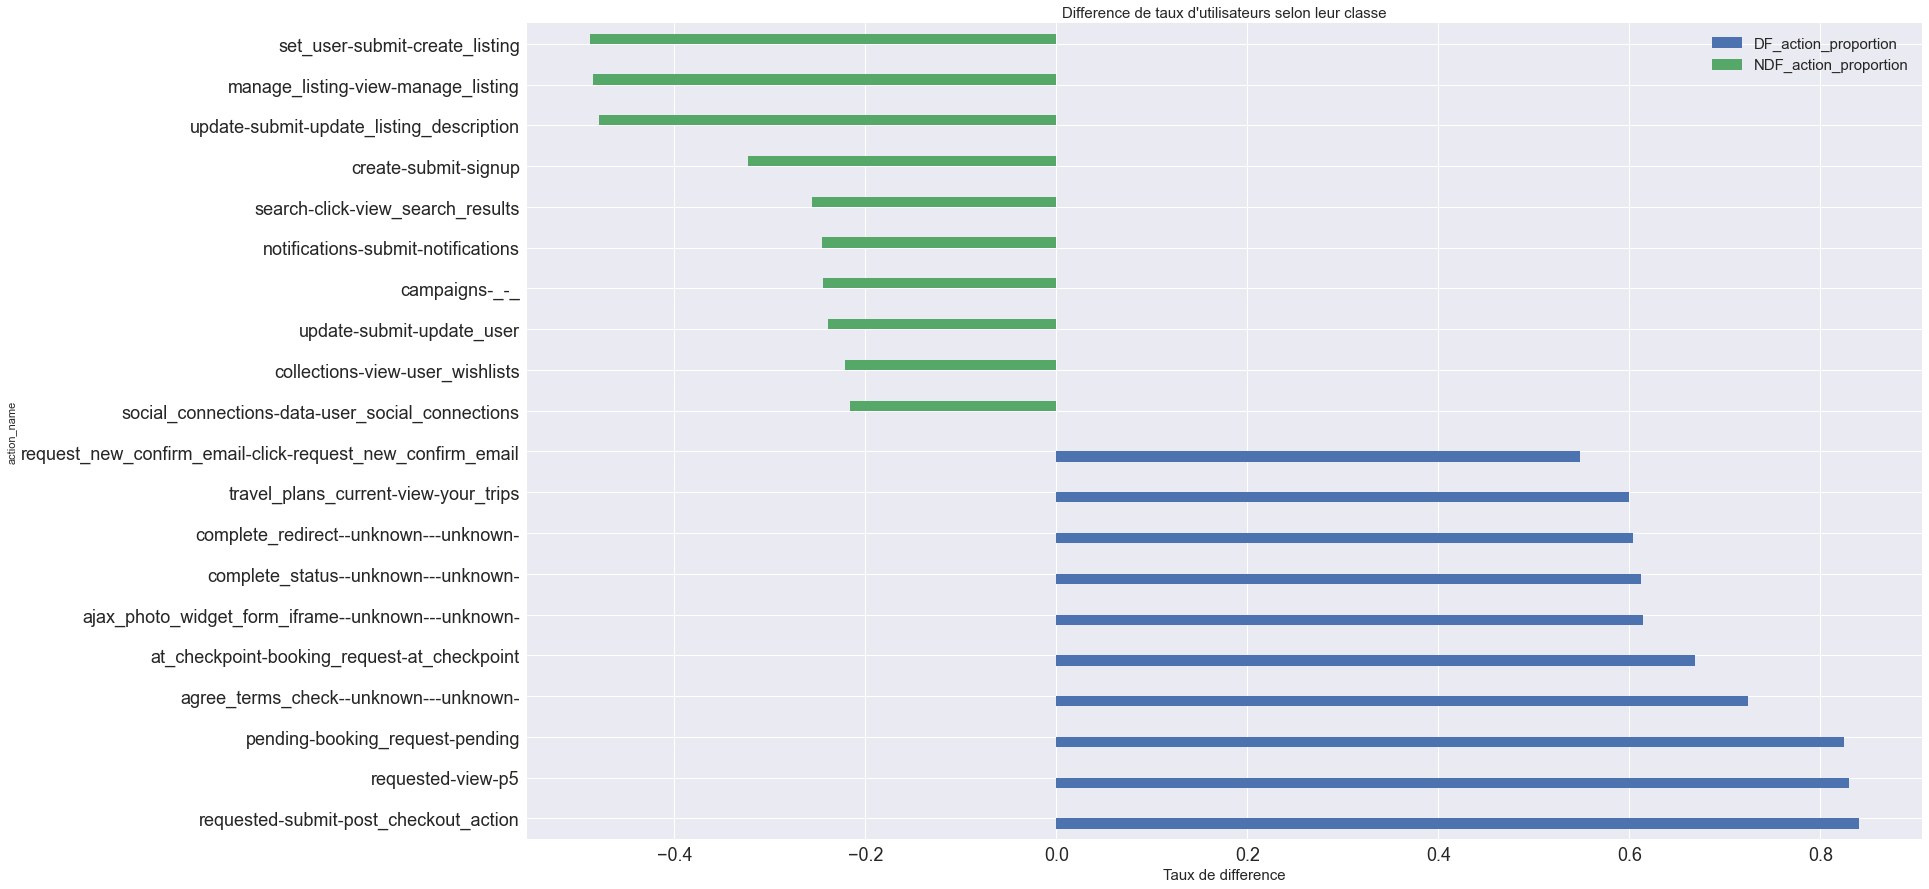

In [10]:
# Display the most common actions among DF but not among NDF and vice-cersa
n_top = 10
n_actions = 1000  # Threshold of the number of users to reach in order to consider the  action, otherwise it is ignored
ndf_actions_names_stats = action_names_stats[action_names_stats['count_df'] + action_names_stats['count_ndf'] > n_actions].sort_values(by='diff').head(n_top).sort_values(by='diff', ascending=False).reset_index()
df_actions_names_stats = action_names_stats[action_names_stats['count_df'] + action_names_stats['count_ndf'] > n_actions].sort_values(by='diff').tail(n_top).sort_values(by='diff', ascending=False).reset_index()
names_stats = pd.DataFrame({
    'action_name': df_actions_names_stats['action_name'].values.tolist() + ndf_actions_names_stats['action_name'].values.tolist(),
    'DF_action_proportion': df_actions_names_stats['diff'].values.tolist() +  [0 for _ in range(ndf_actions_names_stats.shape[0])],
    'NDF_action_proportion': [0 for _ in range(df_actions_names_stats.shape[0])] + ndf_actions_names_stats['diff'].values.tolist(),
})
ax = names_stats.set_index('action_name').plot.barh(figsize=(25, 15), fontsize=18)
ax.set_title("Difference de taux d'utilisateurs selon leur classe", fontsize=15)
ax.set_xlabel('Taux de difference', fontsize=15)
_ = plt.legend(fontsize=15)
# print(f"Combinaisons d'actions propres aux DF : \n{df_actions_names_stats['action_name'].values.tolist()}")
# print(f"Combinaisons d'actions propres aux NDF : \n{ndf_actions_names_stats['action_name'].values.tolist()}")

Ici, on vient d'afficher, les 10 actions les plus fréquents chez les NDF et chez les DF en ordonnée. La fréquence d'une action est calculée selon la différence d'apparition chez les DF et les NDF divisée par le nombre total d'apparition au sein des utilisateurs. Plus cette valeur est proche de +1, plus cette action est propre aux DF. Plus cette valeur est proche de -1, plus cette action est propre aux NDF. On ne garde uniquement les actions qui ont été effectuées par au moins 500 utilisateurs.

On voit sur le graphique que les DF ont une forte tendance à effectuer les actions liées aux réservations : soumettre la requête de réservation ("requested"), mis en attente ("pending"), "agree_terms_check", communiquer avec l'hôte ("message_to_host_change", 'message_to_host_focus")...

Les actions relatives au terme "listing" renvoient au processus de création ou mise à jour d'une page d'un logement. Ce sont donc des actions liées aux hôtes qui louent leur logement. C'est ce qu'on voit dans les actions les plus effectuées parmi les NDF : "manage_listing" et "set_user-submit-create_listing". Ainsi, une portion des NDF sont des hôtes.

Affichons le nombre d'utilisateurs qui ont réalisé ces actions.

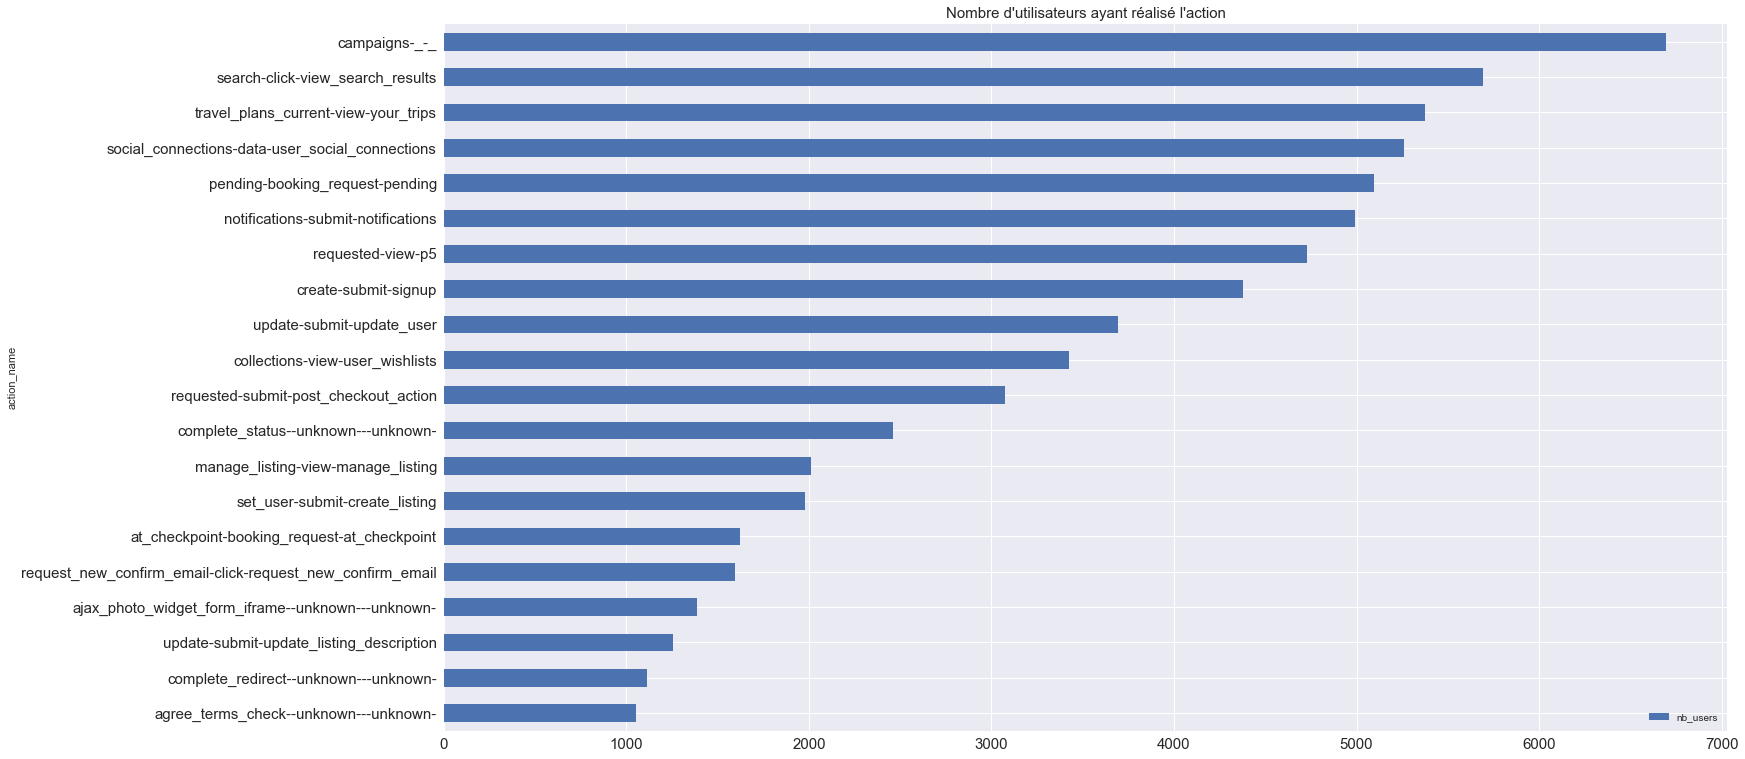

In [11]:
# Have a look at how many users have actually done a specified action found previously
def count_users_who_did(action):
    return sessions[sessions['action_name'] == action]['user_id'].nunique()

actions_names = set(names_stats['action_name'].unique())
names_stats['nb_users'] = names_stats.apply(lambda r: count_users_who_did(r['action_name']), axis=1)
ax = names_stats.sort_values(by='nb_users').plot.barh(x='action_name', y='nb_users', figsize=(23, 13), fontsize=15)
_ = ax.set_title("Nombre d'utilisateurs ayant réalisé l'action", fontsize=15)

On voit que chacune de ces actions n'ont à peine été effectuées par 7000 utilisateurs et ne font donc pas l'unanimité. 

Tentons de chercher les actions les plus communes pour qu'on ait au moins une information sur chaque utilisateur au niveau de son historique d'activités.

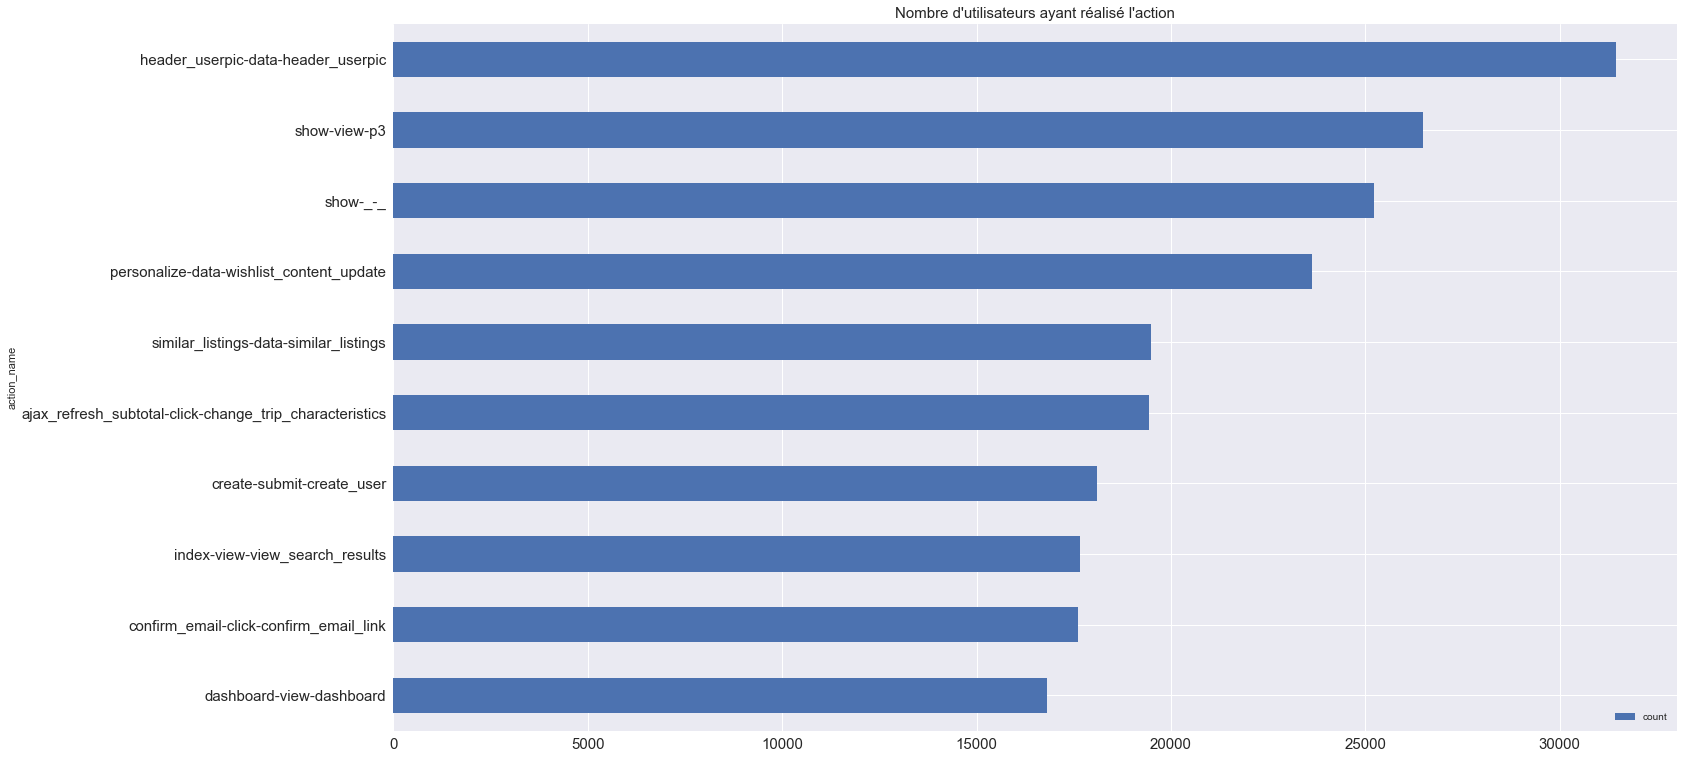

In [12]:
action_names_stats['count'] = action_names_stats['count_df'] + action_names_stats['count_ndf']
action_names_stats.sort_values('count').tail(10).action_name.values.tolist()
ax = action_names_stats.sort_values(by='count').tail(10).plot.barh(x='action_name', y='count', figsize=(23, 13), fontsize=15)
_ = ax.set_title("Nombre d'utilisateurs ayant réalisé l'action", fontsize=15)

In [13]:
names_stats.set_index('action_name').index.values.tolist()

['requested-submit-post_checkout_action',
 'requested-view-p5',
 'pending-booking_request-pending',
 'agree_terms_check--unknown---unknown-',
 'at_checkpoint-booking_request-at_checkpoint',
 'ajax_photo_widget_form_iframe--unknown---unknown-',
 'complete_status--unknown---unknown-',
 'complete_redirect--unknown---unknown-',
 'travel_plans_current-view-your_trips',
 'request_new_confirm_email-click-request_new_confirm_email',
 'social_connections-data-user_social_connections',
 'collections-view-user_wishlists',
 'update-submit-update_user',
 'campaigns-_-_',
 'notifications-submit-notifications',
 'search-click-view_search_results',
 'create-submit-signup',
 'update-submit-update_listing_description',
 'manage_listing-view-manage_listing',
 'set_user-submit-create_listing']

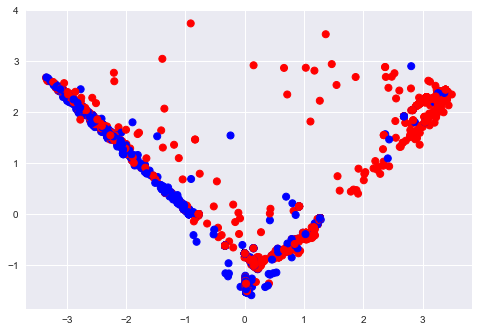

In [14]:
# Encode actions
one_hot_encoded_actions = pd.get_dummies(sessions[['user_id', 'action_name']], columns=['action_name'])

# Generate functions for aggretation
columns = one_hot_encoded_actions.columns.values.tolist()
columns.remove('user_id')
agg_funcs = {col_name: sum for col_name in columns}

# Aggretate actions by users
actions_matrix = one_hot_encoded_actions.groupby('user_id').agg(agg_funcs)
actions_matrix.head()

# Selecting the most relevent columns
cols = ['action_name_' + name for name in names_stats.set_index('action_name').index.values]
m = actions_matrix[cols].div(actions_matrix[cols].std(axis=1), axis=0).fillna(0)

# PCA fit transform
from sklearn.decomposition import PCA
n = 5000
pca = PCA(n_components=2).fit(m)
data = pca.transform(m.iloc[:n])

# Plot with colors
tmp_users = users.set_index('id')
colors = np.array([[1, 0, 0, 1] if tmp_users.loc[user_id, 'found_destination'] == 'DF' else [0, 0 ,1, 1] for user_id in actions_matrix.index])
plt.scatter(data[:,0], data[:,1], color=colors[:n], linewidth=1)

## Le nombre d'actions effectuées par les utilisateurs

On va dresser le liste des actions réalisées par chaque utilisateur afin d'en exhiber le nombre.

In [15]:
# For each user, make a list of his actions in a DataFrame
action_names = sessions.groupby(['user_id', 'found_destination']).agg({'action_name': pd.Series.tolist}).reset_index()
action_names['number_actions'] = action_names.apply(lambda r: r['action_name'].__len__(), axis=1)
action_names['number_unique_actions'] = action_names.apply(lambda r: set(r['action_name']).__len__(), axis=1)
action_names.head()

,user_id,found_destination,action_name,number_actions,number_unique_actions
0,00023iyk9l,DF,"[index-view-view_search_results, dashboard-vie...",40,15
1,001wyh0pz8,NDF,"[search-click-view_search_results, search-clic...",90,12
2,0028jgx1x1,NDF,"[show-view-user_profile, reviews-data-listing_...",31,6
3,00389675gq,NDF,"[similar_listings-data-similar_listings, edit-...",177,50
4,006mls2sjw,DF,"[personalize-data-wishlist_content_update, sim...",195,27


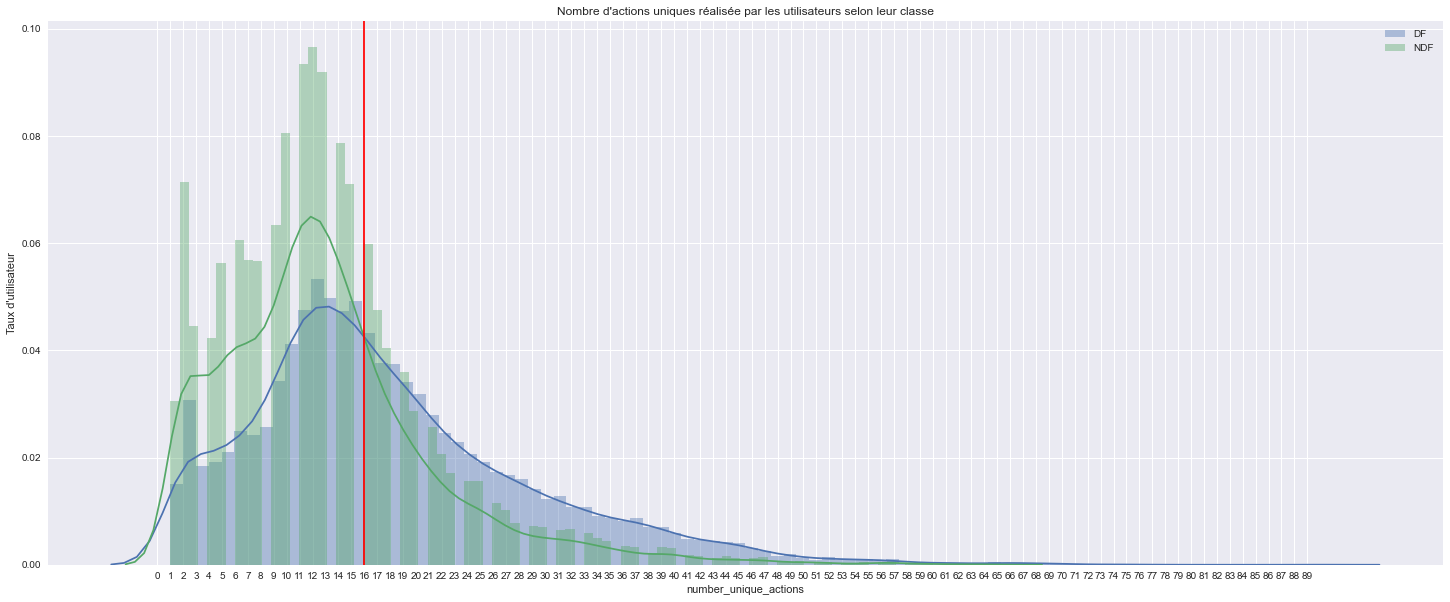

In [16]:
plt.figure(figsize=(25, 10))
n_max = action_names['number_unique_actions'].max()
sns.distplot(action_names[action_names['found_destination'] == 'DF']['number_unique_actions'], bins=n_max, label='DF')
sns.distplot(action_names[action_names['found_destination'] == 'NDF']['number_unique_actions'], bins=n_max, label='NDF')
plt.axvline(16, 0, 1, color='r')
plt.xticks(range(n_max))
plt.ylabel("Taux d'utilisateur")
plt.legend()
_ = plt.title("Nombre d'actions uniques réalisée par les utilisateurs selon leur classe")

On voit que le nombre d'actions uniques chez les NDF est généralement moindre que chez les DF. En effet, on voit une séparation où la densité est plus forte du côté des NDF en-dessous de 16 actions différentes et une densité plus forte du côté des DF après cette valeur. 

## Le type d'appareil utilisé

On va étudier la variable "device_type".

In [17]:
devices = sessions.groupby('user_id').agg({'found_destination': lambda r: r.iloc[0],
                                'secs_elapsed': lambda r: round(r.sum() / (60**2), 0),
                                'device_type': lambda r: r.values.tolist(),
                                'action_name': lambda r: r.shape[0],})

devices = devices.rename({'action_name': 'nb_actions', 'secs_elapsed': 'hours_elapsed'}, axis=1)
for device_type in sessions['device_type'].unique():
    devices[device_type + '_count'] = devices.apply(lambda r: r['device_type'].count(device_type), axis=1)
    
users_as_id = users.set_index('id')
devices['first_device_type'] = devices.apply(lambda r: users_as_id.loc[r.name]['first_device_type'], axis=1)
devices['device_type'] = devices.apply(lambda r: set(r['device_type']), axis=1)
devices.head(3)

,found_destination,hours_elapsed,device_type,nb_actions,iPhone_count,Mac Desktop_count,iPad Tablet_count,Android App Unknown Phone/Tablet_count,-unknown-_count,Windows Desktop_count,Android Phone_count,Linux Desktop_count,Tablet_count,Chromebook_count,Blackberry_count,Windows Phone_count,iPodtouch_count,Opera Phone_count,first_device_type
user_id,,,,,,,,,,,,,,,,,,,
00023iyk9l,DF,241.0,"{Mac Desktop, iPhone}",40,4,36,0,0,0,0,0,0,0,0,0,0,0,0,Mac Desktop
001wyh0pz8,NDF,79.0,{Android App Unknown Phone/Tablet},90,0,0,0,90,0,0,0,0,0,0,0,0,0,0,Other/Unknown
0028jgx1x1,NDF,83.0,"{Android Phone, -unknown-}",31,0,0,0,0,30,0,1,0,0,0,0,0,0,0,Android Phone


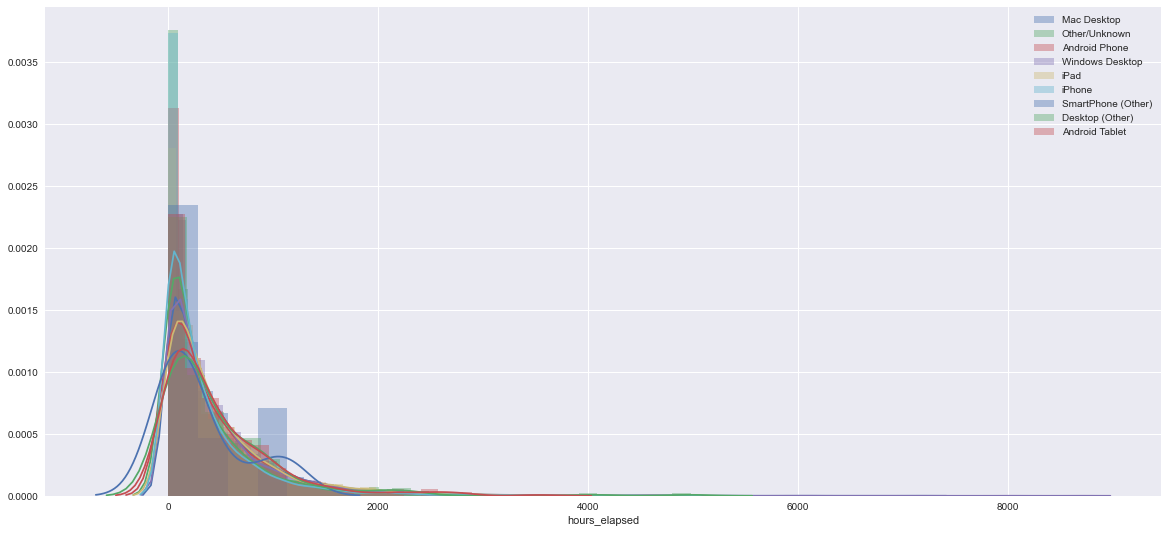

In [18]:
plt.figure(figsize=(20, 9))
for device_type in devices['first_device_type'].unique():
    sns.distplot(devices[devices['first_device_type'] == device_type]['hours_elapsed'], label=device_type)
plt.legend()

## Récapitulatif

* En général, les DF passent plus de temps sur la plateforme que les NDF.
* On peut exhiber, parmi les NDF, des utilisateurs hôtes qui louent un logement, grâce à l'historique de leurs actions.
* On retrouve, parmi les DF, les actions liées à la réservation (demande de réservation, message envoyé à l'hôte...)
* 